# Model Assessment


**Data Science for Business - Instructor:  Chris Volinsky**

**Original Notebooks courtesy of Prof. Foster Provost and Rubing Li**

***

Import all of the packages we will need.

In [ ]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


import matplotlib.pylab as plt
%matplotlib inline
# plt.rcParams['figure.figsize'] = 15, 12

### Data Input, EDA, and Data Cleaning
We're going to use a mail response data set from a real direct marketing campaign.  [You can download the data here](https://drive.google.com/uc?export=download&id=1deEx-Ey37F7qznPlIqmaAjjkmkvBtV28).  Each record represents an individual who was targeted with a direct marketing offer.  The offer was a solicitation to make a charitable donation.

The columns (features) are:

```
income       household income
Firstdate    data assoc. with the first gift by this individual
Lastdate     data associated with the most recent gift
Amount       average amount by this individual over all periods (incl. zeros)
rfaf2        frequency code
rfaa2        donation amount code
pepstrfl     flag indicating a star donator
glast        amount of last gift
gavr         amount of average gift
```

The target variables is `class` and is equal to one if they gave in this campaign and zero otherwise.

In [ ]:
# read in csv file from my computer

from google.colab import files
uploaded = files.upload()


In [ ]:
df = pd.read_csv('DirectMarketing.csv') # replace 'your_file.csv' with your file name
# Now you can work with the dataframe df


In [ ]:
df.info()
df.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191779 entries, 0 to 191778
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Income     191779 non-null  int64  
 1   Firstdate  191779 non-null  int64  
 2   Lastdate   191779 non-null  int64  
 3   Amount     191779 non-null  float64
 4   rfaf2      191779 non-null  int64  
 5   rfaa2      191779 non-null  object 
 6   pepstrfl   191779 non-null  object 
 7   glast      191779 non-null  int64  
 8   gavr       191779 non-null  float64
 9   class      191779 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 14.6+ MB


,Income,Firstdate,Lastdate,Amount,rfaf2,glast,gavr,class
count,191779.00,191779.00,191779.00,191779.00,191779.00,191779.00,191779.00,191779.00
mean,3.02,9136.56,9548.17,0.17,1.91,17.39,13.35,0.05
std,2.30,319.23,49.38,0.10,1.07,28.38,10.14,0.22
min,0.00,0.00,9503.00,0.02,1.00,0.00,1.28,0.00
25%,1.00,8811.00,9509.00,0.10,1.00,10.00,8.40,0.00
50%,3.00,9201.00,9512.00,0.15,1.00,15.00,11.66,0.00
75%,5.00,9409.00,9602.00,0.22,3.00,20.00,15.50,0.00
max,7.00,9603.00,9702.00,1.76,4.00,10000.00,1000.00,1.00


In [ ]:
df.head() # note the cateogricals, that dont show up in .describe

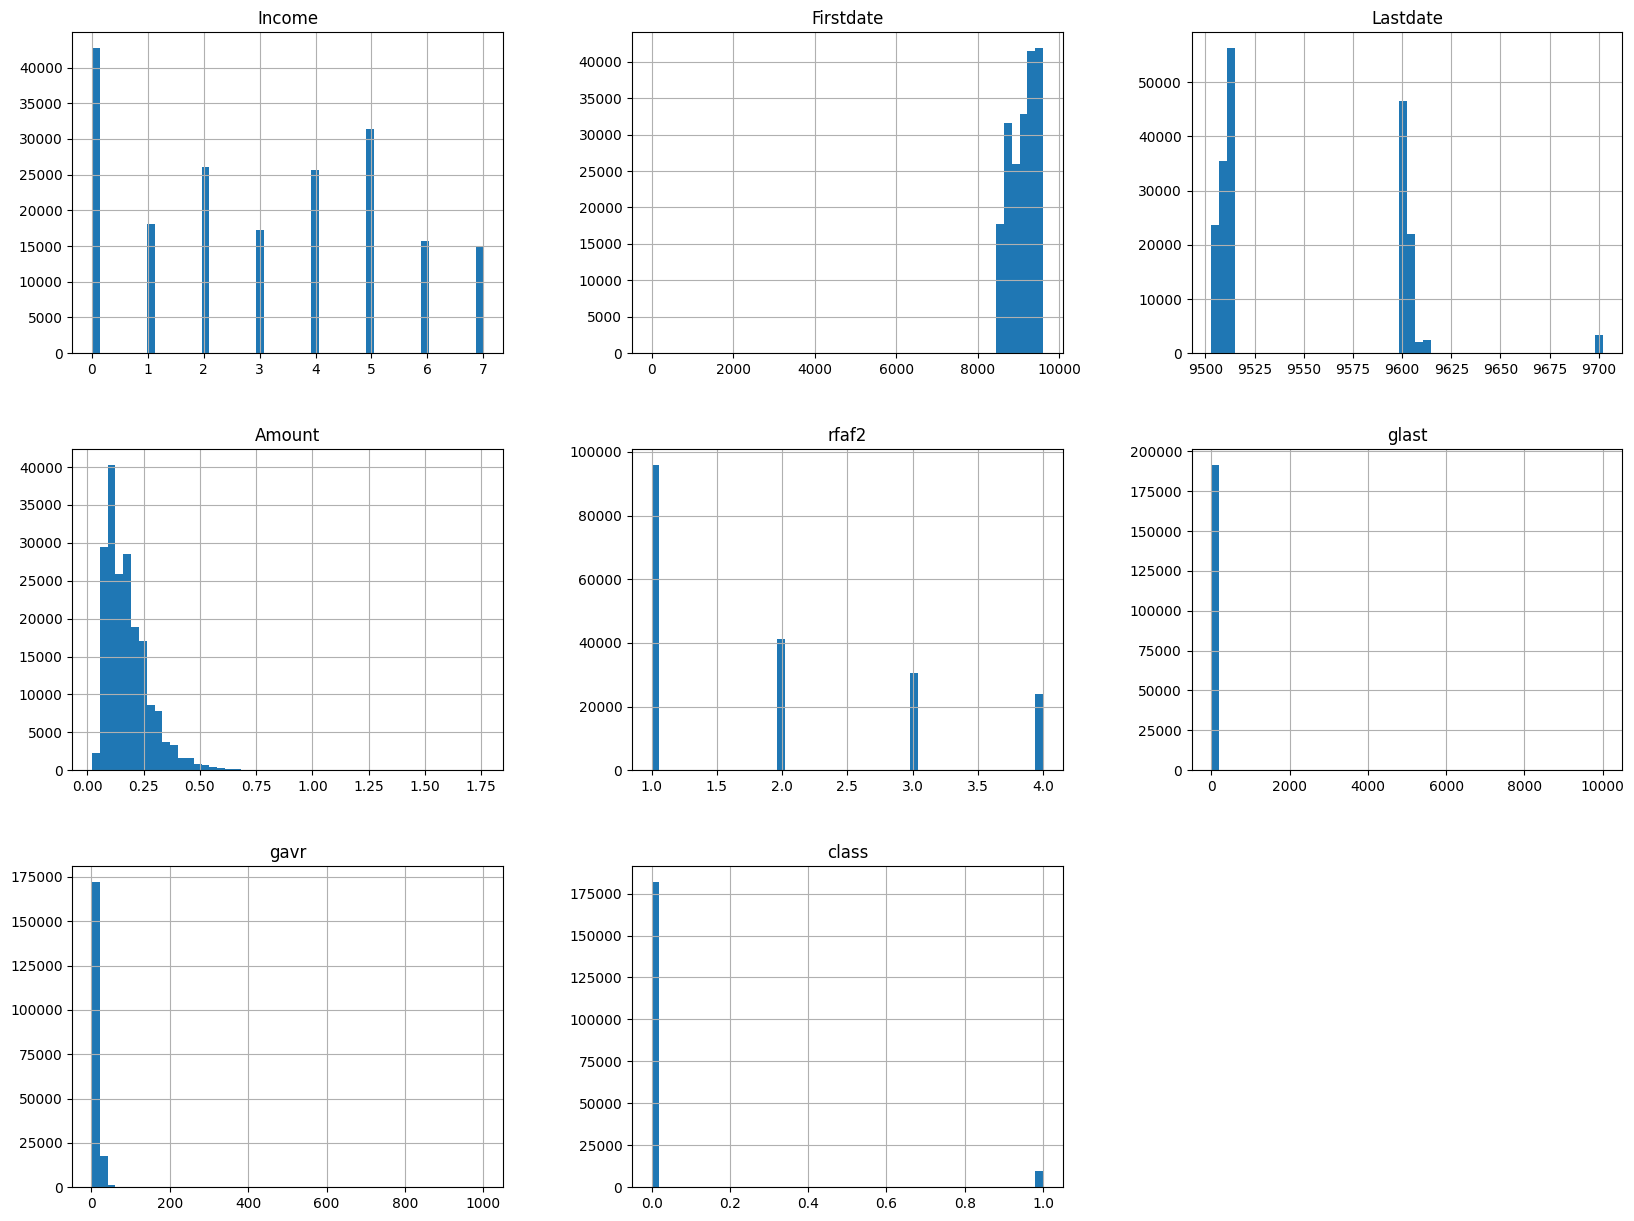

In [ ]:
#plot histograms of all features

df.hist(bins=50, figsize=(20, 15))
plt.show()

We need to do some cleaning here...

- There are no missing values, but there are 4 cases where Firstdate is zero.  We can remove those.

- We have two heavily skewed features - `gavr` and `glast` - which we might want to consider transformations.  We will be fitting a regression model, so it is best not to have skewed features.

- our target is unbalanced (5% class == 1), we might consider balancing it, but for now, no.

- need to create dummies for our categorical features (rfaa2 and pepstrfl), but there are others that are also categorical but not coded that way (income and rfaf2)

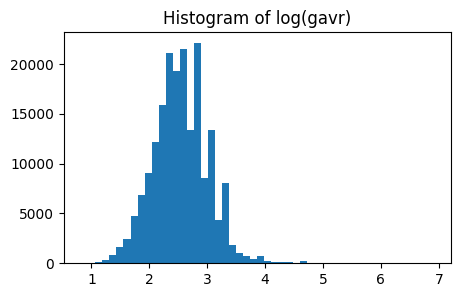

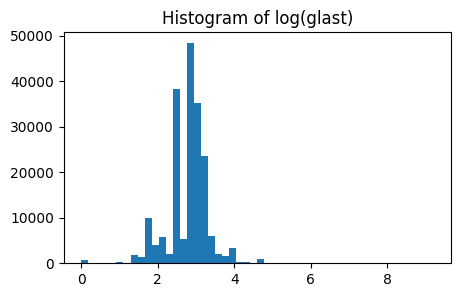

In [ ]:
# lets look closer at our very skewed features
#plot histograms of the log gavr and glast next to each other

plt.figure(figsize=(5,3))
plt.hist(np.log(df.gavr+1), bins=50,ec='black')
plt.title('Histogram of log(gavr)')
plt.show()
plt.figure(figsize=(5,3))
plt.hist(np.log(df.glast+1), bins=50,ec='black')
plt.title('Histogram of log(glast)')
plt.show()

In [ ]:
# remove cases where Firstdate == 0 using .loc
df = df.loc[df.Firstdate != 0]

# replace gavr and glast with log versions of same features using .loc
df_clean = df
df_clean['gavr'] = np.log(df.gavr+1)
df_clean['glast'] = np.log(df.glast+1)



<ipython-input-8-5fae1037f7d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['gavr'] = np.log(df.gavr+1)
<ipython-input-8-5fae1037f7d4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['glast'] = np.log(df.glast+1)


We want to create dummies for all of our categorical features.  But two of them (Income and rfaf2) are not yet recognized as categorical.  So we need to change them, and then create the dummies, for them and the other features `rfaa2` and `pepstrfl`.

Use `drop_first=True` to create k-1 dummies as discussed in class.

In [ ]:
income_cat = pd.Categorical(df['Income'], categories=[0,1,2,3,4,5,6,7])
df_clean['Income'] = income_cat

rfaf2_cat = pd.Categorical(df['rfaf2'], categories=[1,2,3,4])
df_clean['rfaf2'] = rfaf2_cat

df_clean = pd.get_dummies(df_clean, columns=['rfaa2', 'pepstrfl','Income','rfaf2'],drop_first=True)
df_clean.head()


,Firstdate,Lastdate,Amount,glast,gavr,class,rfaa2_E,rfaa2_F,rfaa2_G,pepstrfl_X,Income_1,Income_2,Income_3,Income_4,Income_5,Income_6,Income_7,rfaf2_2,rfaf2_3,rfaf2_4
0,9409,9509,0.06,3.931826,3.433987,0,False,False,True,False,False,False,True,False,False,False,False,False,False,False
1,9201,9602,0.16,3.044522,3.070376,1,False,False,True,True,False,True,False,False,False,False,False,False,False,True
2,9510,9603,0.20,1.791759,2.277267,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,9409,9603,0.13,3.258097,3.157000,0,False,False,True,False,False,False,False,False,False,True,False,True,False,False
4,9310,9511,0.10,3.258097,2.602690,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False


Think about the date features Firstdate and Lastdate...are these informative?  How might we make them more interesting?

Maybe let:

*tenure* = Lastdate-Firstdate

and

*recency* = Today-Lastdate

(we dont know the date the data was collected or what these numbers mean - so lets just use the most recent date (max(lastdate)) as today

In [ ]:
# Create a new feature 'tenure'
df_clean['tenure'] = df_clean['Lastdate'] - df_clean['Firstdate']

# maybe check to see this is always greater than zero?
df_clean['tenure'].min()


0

In [ ]:
# assign "today" as the max value of Lastdate, and calculate "recency" as the difference between today and Lastdate

today = df_clean['Lastdate'].max()
df_clean['recency'] = today - df_clean['Lastdate']

# remove Firstdate and Lastdate
df_clean = df_clean.drop(['Firstdate', 'Lastdate'], axis=1)


In [ ]:
df_clean.head()

,Amount,glast,gavr,class,rfaa2_E,rfaa2_F,rfaa2_G,pepstrfl_X,Income_1,Income_2,Income_3,Income_4,Income_5,Income_6,Income_7,rfaf2_2,rfaf2_3,rfaf2_4,tenure,recency
0,0.06,3.931826,3.433987,0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,100,193
1,0.16,3.044522,3.070376,1,False,False,True,True,False,True,False,False,False,False,False,False,False,True,401,100
2,0.20,1.791759,2.277267,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,93,99
3,0.13,3.258097,3.157000,0,False,False,True,False,False,False,False,False,False,True,False,True,False,False,194,99
4,0.10,3.258097,2.602690,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,201,191


### Build the model

We are going to build a model - specifically Logistic Regression (a type of classification model - NOT a regression model 🤯).   But the model is not useful until we apply *decision logic*, specfically defining the threshold that we will use to determine the action we will take.

In [ ]:
# Split our data into training and test sets
# remove the features we dont need anymore from our X features
X = df_clean.drop(['class'], axis=1)
Y = df_clean['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

# Make and fit a model on the training data
model_lr = LogisticRegression(C=100000,solver = 'liblinear')
  # C is a regularlization parameter, will discuss in next chapter
  # liblinear is a good general purpose solver (algorithm)
model_lr.fit(X_train, Y_train)

# Get probabilities of being a donor
probabilities = model_lr.predict_proba(X_test)[:, 1]

Use the default threshold of 50% to decide Y vs N.

(An individual below this threshold will get a prediction of "0" and someone above this will get a prediction of "1")

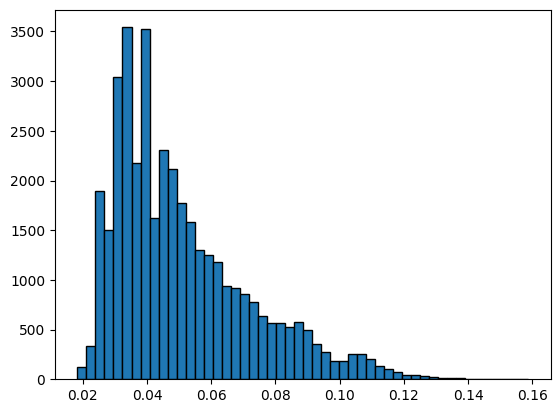

In [ ]:
#plot histogram of probabilities
plt.hist(probabilities, bins=50,edgecolor='black')
plt.show()

What do you notice about the probabilities?

Here is an example where using a 0.5 threshold does not make sense!  

Pick a sensible threshold and use it to define your predicted probabilities

In [ ]:
thresh = 0.10

pred_giver = probabilities > thresh

# how many predicted givers are there?
print("Total predicted to give: ",pred_giver.sum())
print("% predicted to give: ", pred_giver.mean().round(3))

#probabilities > = 0/05).value_counts()

Total predicted to give:  1392
% predicted to give:  0.036


## Evaluating the Model with a Confusion Matrix

Remember that the confusion matrix is a function of the model (Logistic Regression) but also the decision logic (threshold)  that we set.


In [ ]:
conf_mat = pd.DataFrame(metrics.confusion_matrix(Y_test, pred_giver,labels=[1,0]).T)
# Taking the transpose (.T) of the confusion matrix is not necessary,
# but it makes it so that the conf mat is the same orientation as in our slides
conf_mat.columns=['Actual1', 'Actual0']
conf_mat.index=['Pred1', 'Pred0']
conf_mat

,Actual1,Actual0
Pred1,156,1236
Pred0,1790,35173


Can you calculate the metrics we have learned?:
- accuracy
- precision
- recall
- F1

I'm sure you can!!  🧠

But Python can do it too...

In [ ]:

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

precision = precision_score(Y_test, pred_giver)
recall = recall_score(Y_test, pred_giver)
accuracy = accuracy_score(Y_test, pred_giver)
f1 = f1_score(Y_test, pred_giver)


print("Precision:", round(precision,3))
print("Recall:", round(recall,3))
print("Accuracy:", round(accuracy,3))
print("F1 Score:", round(f1,3))


Precision: 0.112
Recall: 0.08
Accuracy: 0.921
F1 Score: 0.093


**Also: What percentage of your customer base are you marketing to with this threshold???**



***
Is this good performance?

How can we tell?

Is your threshold the right threshold?  How would we determine that?

## ROC Curves and AUC for comparing models

Remember that the Area under the ROC curve (AUC) is a single value to compare models across all thresholds




Using several classification models, we will plot  *ROC curves* and overlay them to see which has the best performance.


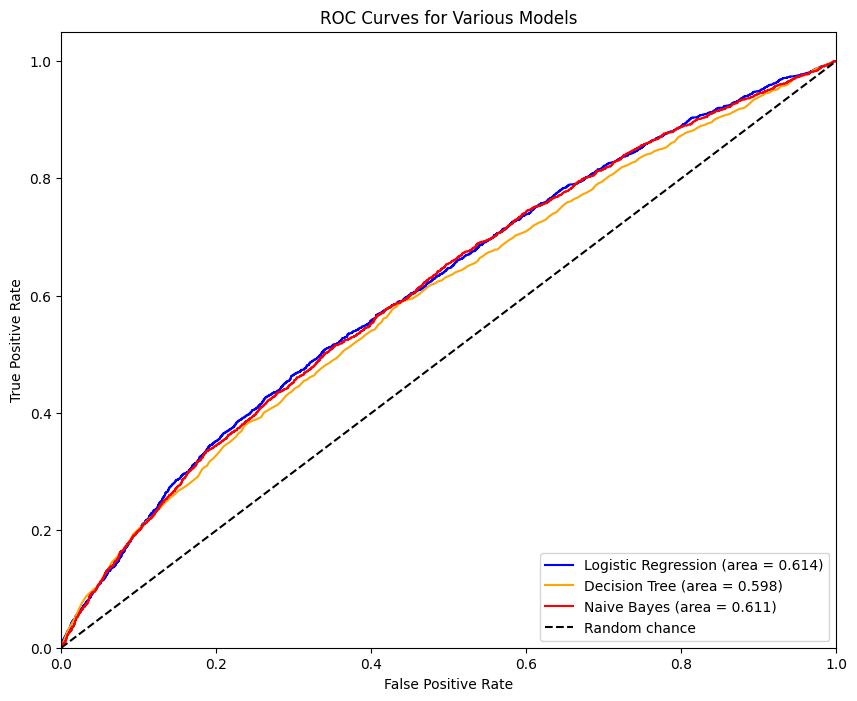

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(C=10000, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(criterion="entropy", min_samples_leaf=500, random_state=42),
    'Naive Bayes': GaussianNB(),
}

colors = {
    'Logistic Regression': 'blue',
    'Decision Tree': 'orange',
    'Naive Bayes': 'red',
}

# Dictionary to hold ROC data
roc_data = {}

for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = metrics.roc_auc_score(Y_test, Y_pred_proba)
    roc_data[name] = (fpr, tpr, roc_auc)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.3f})',color=colors[name])

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()


Who is the winner?  
Lets take a look at other curves...

## Cumulative response and lift curves

ROC is a useful curve to compare models in many situations.  But sometimes this interpretation can be confusing to stakeholders.  

 In some applications the **cumulative response curve** and its associated **lift curve** can be more useful.  Specifically in cases - like targeted advertising - where you will be taking action on a small percentage of your customer base, the lift curve has an appealing interpretation : "How much better does my model do than random chance"?   The lift curve allows comments like **our best model improves our targeting by 4.5x**





Unfortunately, Python does not have a built in model to calculate these curves, so we will provide some user-built functions ...

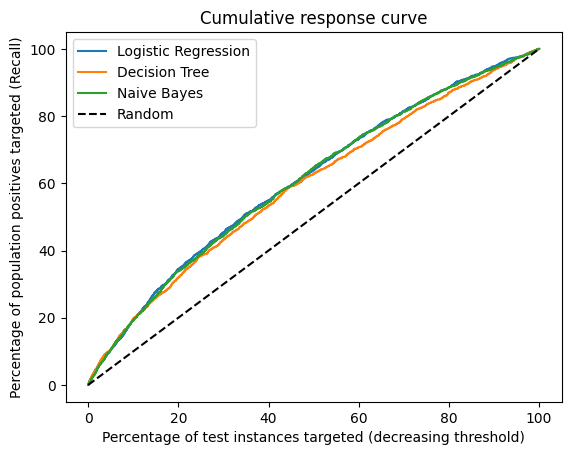

In [ ]:
def build_cumulative_curve(model, scale=100):
    # Fit model
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probs = model.predict_proba(X_test)[:, 1]

    # Sort these probabilities and the true value in descending order of probability
    order = np.argsort(Y_test_probs)[::-1]
    Y_test_probs_sorted = Y_test_probs[order]
    Y_test_sorted = np.array(Y_test)[order]

    # Build the cumulative response curve
    x_cumulative = np.arange(len(Y_test_probs_sorted)) + 1
    y_cumulative = np.cumsum(Y_test_sorted)

    # Rescale
    x_cumulative = np.array(x_cumulative)/float(x_cumulative.max()) * scale
    y_cumulative = np.array(y_cumulative)/float(y_cumulative.max()) * scale

    return x_cumulative, y_cumulative

def plot_cumulative_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [0,100], 'k--', label="Random")
    plt.xlabel("Percentage of test instances targeted (decreasing threshold)")
    plt.ylabel("Percentage of population positives targeted (Recall)")
    plt.title("Cumulative response curve")
    plt.legend()

plot_cumulative_curve(models)

We can also plot a **lift curve** in this scenario.  What if we specfically only want to market to the top 1% of our customer base?  Which is best?

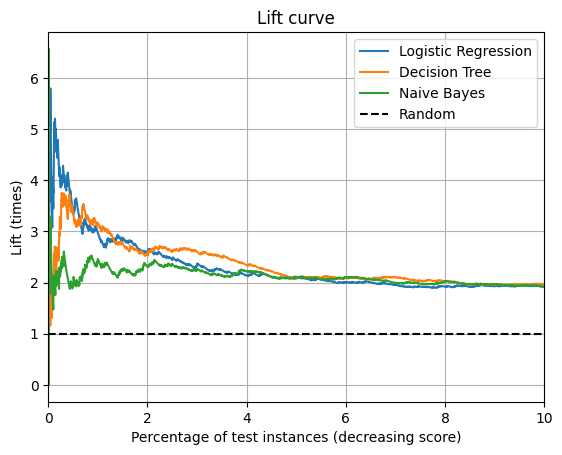

In [ ]:
def plot_lift_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative/x_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [1,1], 'k--', label="Random")
    plt.xlabel("Percentage of test instances (decreasing score)")
    plt.ylabel("Lift (times)")
    plt.title("Lift curve")
    plt.legend()
    plt.grid()
    plt.xlim(0, 10)  # Set x-axis limits to 0-20

plot_lift_curve(models)

## NOTE, might want to focus on left side of plot: plt.xlim(0, 10)

What if we want to understand not just lift, but how much benefit we are going to receive from a certain investment in targeting?  We can plot a profit curve.


## Profit curves
Let's say that each offer costs \$1 to make and market, and each accepted offer earns \$18, for a profit of $17. The cost matrix would be:


In [ ]:
unit_cost = 2
unit_revenue = 25

cost_matrix = pd.DataFrame([[unit_revenue - unit_cost, - unit_cost], [0, 0]], columns=['Actual1', 'Actual0'], index=['Pred1', 'Pred0'])
print ("Cost matrix")
print (cost_matrix)

Cost matrix
       Actual1  Actual0
Pred1       23       -2
Pred0        0        0


Remember that we examined different targeting thresholds (aka "decision thresholds"):

In [ ]:
print ("Confusion matrix with threshold =",thresh,"to send marketing:\n")
print (conf_mat)
print ("\n")
# print ("Confusion matrix with threshold = 5% to predict labels")
# print (confusion_matrix_5)

Confusion matrix with threshold = 0.1 to send marketing:

       Actual1  Actual0
Pred1      156     1236
Pred0     1790    35173




In [ ]:
#multiply the confusion matrix by the cost matrix, element wise, and add up the values

import numpy as np
profit = np.sum(np.multiply(conf_mat.values, cost_matrix.values))
print("Profit: $",profit)


Profit: $ 1116


Now we can plot the profit curve for the two models.

(Note: to calculate the profit curve, you could simply cycle through all of the possible thresholds(using a `for` loop), and store the profit at each threshold, then plot it.

This version is slightly more efficient.

Max Profit = 2072  with 0.146  % targeted



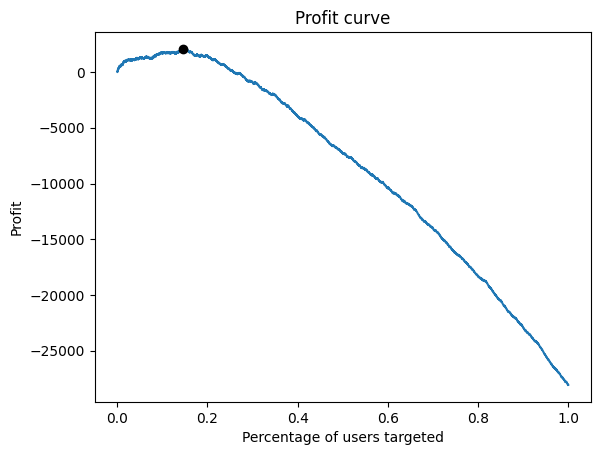

In [ ]:
## METHOD 1 - cycle through all of the possible thresholds(using a for loop), and store the profit at each threshold, then plot it.
## note this is just for one model.


model=LogisticRegression(C=10000, solver='liblinear')
model.fit(X_train, Y_train)

## reorder your probabilities (and associated Y_test values) in order of sorted probabilities
probs = model.predict_proba(X_test)[:, 1]
order = np.argsort(probs)[::-1]
probs_sort = probs[order]
Y_test_sort = np.array(Y_test)[order]

## cycle through the probability thresholds from highest to lowest
## at each stage, calculate number marketed to, and the number customers donating
xvec = []
yvec = []
tot_obs = len(Y_test)
tot_pos = Y_test.sum()
max_profit = 0
for prob in probs_sort[:tot_obs]:
  pred_pos = probs_sort >= prob
  Y_test[pred_pos].mean()
  num_donated_customers = Y_test_sort[pred_pos].sum()
  expense = unit_cost * pred_pos.sum()
  revenue = unit_revenue * num_donated_customers
  profit = revenue - expense
  xval = pred_pos.sum()/tot_obs
  yval = profit
  if profit > max_profit:
    max_profit = profit
    max_profit_targeted = xval
  xvec.append(xval)
  yvec.append(yval)
 # print(prob, pred_pos.sum(), num_donated_customers, expense, revenue, profit)

print("Max Profit = %.0f" % max_profit," with %.3f" %max_profit_targeted," % targeted\n")
# format the print statement with 3 decimal place


# plot xvec vs yvec
plt.plot(xvec,yvec)
plt.plot(max_profit_targeted, max_profit, 'ko')
plt.xlabel("Percentage of users targeted")
plt.ylabel("Profit")
plt.title("Profit curve")
plt.show()


max profit is 4529.0 with 27.2 % users targeted
max profit is 3957.0 with 24.6 % users targeted
max profit is 4268.0 with 19.4 % users targeted


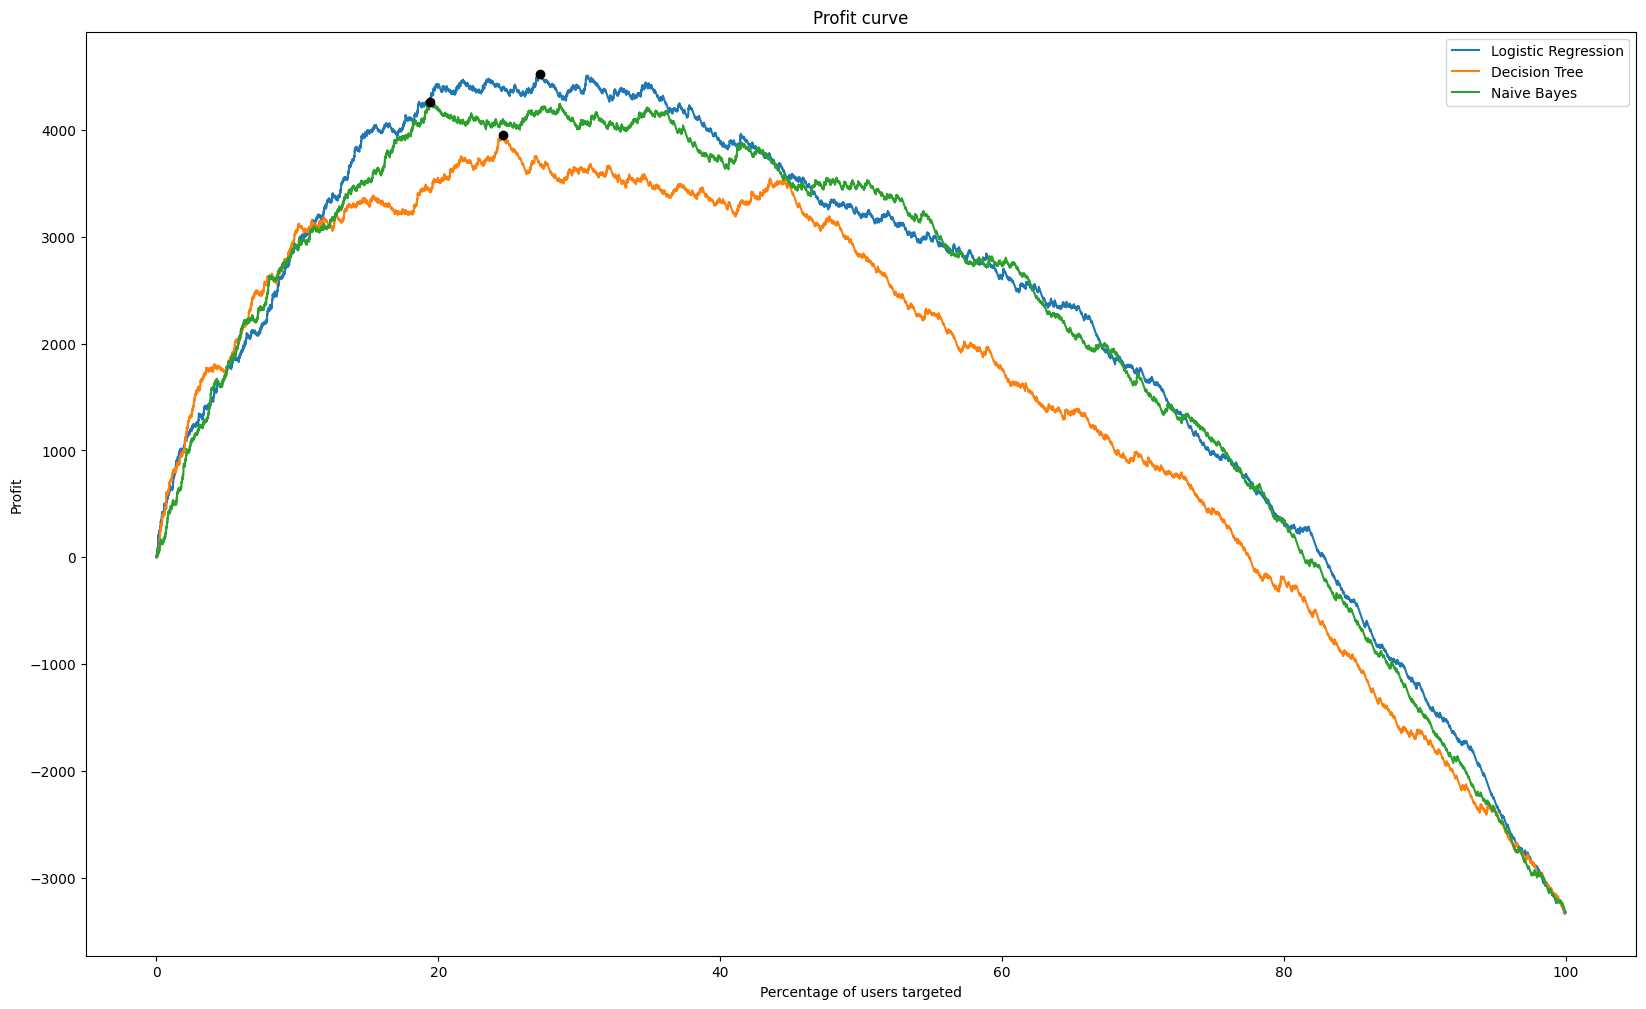

In [ ]:
# METHOD 2 - uses our cumulative response curves from above.

unit_cost = -cost_matrix['Actual0']['Pred1']
unit_revenue = cost_matrix['Actual1']['Pred1'] + unit_cost

def plot_profit_curve(models):
    # Plot curve for each model
    total_obs = len(Y_test)
    total_pos = Y_test.sum()
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key], scale=1)
        # x_cumulative is cumulative vector of what percentage of population I am targeting
        # y_cumulative is cumulative vector of % of positives among those I am targeting
        pos_profit = unit_revenue * y_cumulative * total_pos
        neg_profit = unit_cost * x_cumulative * total_obs
        profits = pos_profit - neg_profit
        max_profit = profits.max().round(2)
        max_profit_targeted = (100 * x_cumulative[profits.argmax(axis=0)]).round(1)
        plt.plot(x_cumulative * 100, profits, label=key)
        print("max profit is",max_profit,"with",max_profit_targeted,"% users targeted")
        plt.plot(max_profit_targeted, max_profit, 'ko')
    # Plot other details
    plt.xlabel("Percentage of users targeted")
    plt.ylabel("Profit")
    plt.title("Profit curve")
    plt.legend()

plt.figure(figsize=(20,12))
plot_profit_curve(models)

Which one do you think we should choose? Why?

## Self-Directed Exercise

Run notebook again by changing things:
- change cost matrix
- add new models
- re-balance data at beginning by sampling class=0 to create a new set with 50% 1s and 0s.  This might allow you to fit more complex models like k-NN or SVM without it taking so long.

